# ******Import necessary libraries and modules **

In [1]:
#import the reqired libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
#from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

# **Read data file from path************

In [2]:
columns=['userId', 'productId', 'ratings','timestamp']
electronics_df=pd.read_csv("../input/csv-data/Electronics.csv",names=columns)

In [3]:
electronics_df.head()

,userId,productId,ratings,timestamp
0,0060009810,A1N070NS9CJQ2I,5.0,1026864000
1,0060009810,A3P0KRKOBQK1KN,5.0,1025913600
2,0060009810,A192HO2ICJ75VU,5.0,1025654400
3,0060009810,A2T278FKFL3BLT,4.0,1025395200
4,0060009810,A2ZUXVTW8RXBXW,5.0,1025222400


# **Exploratory Data Analysis******

In [4]:
electronics_df.drop('timestamp',axis=1,inplace=True)

In [5]:
electronics_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20994353 entries, 0 to 20994352
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   ratings    float64
dtypes: float64(1), object(2)
memory usage: 480.5+ MB


In [6]:
#Check the number of rows and columns
rows,columns=electronics_df.shape
print('Number of rows: ',rows)
print('Number of columns: ',columns)

Number of rows:  20994353
Number of columns:  3


In [7]:
#Check the datatypes
electronics_df.dtypes

userId        object
productId     object
ratings      float64
dtype: object

In [8]:
#Taking subset of the dataset
electronics_df1=electronics_df.iloc[:50000,0:]

In [9]:
electronics_df1['ratings'].describe().transpose()

count    50000.000000
mean         4.123980
std          1.343386
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: ratings, dtype: float64

In [10]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_df1.ratings.min()))
print('Maximum rating is: %d' %(electronics_df1.ratings.max()))

Minimum rating is: 1
Maximum rating is: 5


# **handling missing data******

****

In [11]:
#Check for missing values
print('Number of missing values across columns: \n',electronics_df.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
ratings      0
dtype: int64


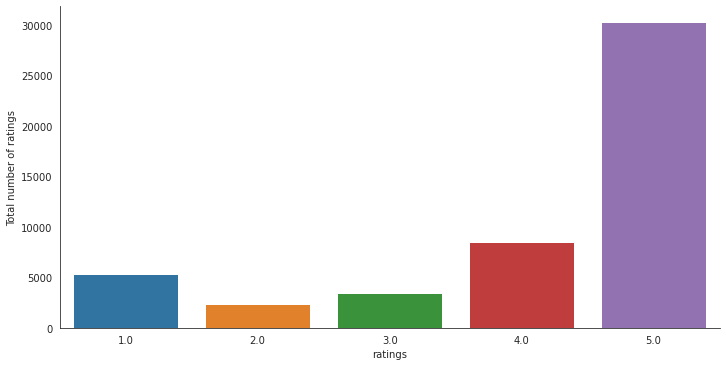

In [12]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("ratings", data=electronics_df1, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [13]:
# Number of unique user id  in the data
print('Number of unique users in Raw data = ', electronics_df1['userId'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', electronics_df1['productId'].nunique())

Number of unique users in Raw data =  669
Number of unique product in Raw data =  48682


# **Taking the subset of dataset to make it less sparse/denser.******

In [14]:
#Check the top 10 users based on ratings
most_rated=electronics_df1.groupby('userId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n',most_rated)

Top 10 users based on ratings: 
 userId
B00001P4ZH    3394
B00001WRSJ    2800
1495443043    1803
0972683275    1456
B00000K135    1371
B00000K2YR    1239
6073894996    1217
B00001P4XA    1069
9573212919    1008
B00001P4XH     952
dtype: int64


In [15]:
counts=electronics_df1.userId.value_counts()
electronics_df1_final=electronics_df1[electronics_df1.userId.isin(counts[counts>=15].index)]
print('Number of users who have rated 25 or more items =', len(electronics_df1_final))
print('Number of unique users in the final data = ', electronics_df1_final['userId'].nunique())
print('Number of unique products in the final data = ', electronics_df1_final['userId'].nunique())

Number of users who have rated 25 or more items = 47978
Number of unique users in the final data =  333
Number of unique products in the final data =  333


# **Ratings analysis in final dataset******

In [16]:
#constructing the pivot table
final_ratings_matrix = electronics_df1_final.reset_index().pivot_table(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
final_ratings_matrix.head()

productId,A01821029CN62H06UXO,A0219337RHNC3U3T12TP,A0232781HWIYKC30FDSP,A0266076X6KPZ6CCHGVS,A0273990TGLE0LLF0H0B,A0289418QDN9OTXLUDEK,A0293130VTX2ZXA70JQS,A0317784S04NV8QVY364,A0385843DE41TCVXH2I1,A05308081UG71LSV3EE3,...,AZZGJ2KMWB7R,AZZGUU97OHUF1,AZZP8BC9WE0N8,AZZST8OYL5P4Q,AZZT9G4MJFCHD,AZZUO98LB93B2,AZZVYHVJ8BDUZ,AZZW390GP15LN,AZZXJAE2DILET,AZZYJH0XNZ896
userId,,,,,,,,,,,,,,,,,,,,,
0060786817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0101635370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0151004714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0373250460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0375503757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (333, 46806)


In [18]:
#Calucating the density of the rating marix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  47859
possible_num_of_ratings =  15586398
density: 0.31%


In [19]:
#Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(electronics_df1_final, test_size = 0.3, random_state=0)
train_data.head()

,userId,productId,ratings
23534,B00000J1T1,A1OQCC7IDGPIF5,5.0
20952,B000001OM5,A335QPS69X83J5,5.0
45373,B00001W0DI,A2JA2LPXKLD93Z,2.0
28664,B00000J1V5,A3FAVTVI5QG121,5.0
18351,9983039281,A3J631XKOM5JUC,5.0


In [20]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (33584, 3)
Shape of testing data:  (14394, 3)


# **Build recommender model**********

In [21]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head(10)

,productId,score
0,A0273990TGLE0LLF0H0B,1
1,A0293130VTX2ZXA70JQS,1
2,A0317784S04NV8QVY364,1
3,A0385843DE41TCVXH2I1,1
4,A0821988FXKFYX53V4QG,1
5,A1003EYWAQFOUG,1
6,A1005332P0RIWL,1
7,A1008Z48LB2QI4,1
8,A100AQOVAMS0P9,1
9,A100B7JCCGVUK8,1


In [22]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,productId,score,rank
10086,A25E8V5JMW43RY,8,1.0
29026,AJJV9Z17KV6GR,6,2.0
13765,A2L7WYA5OENV03,5,3.0
19811,A3A15L96IYUO6V,5,4.0
345,A11ED8O95W2103,4,5.0


In [23]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [24]:
find_recom = [10,100,150]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n")

The list of recommendations for the userId: 10

       userId       productId  score  rank
10086      10  A25E8V5JMW43RY      8   1.0
29026      10   AJJV9Z17KV6GR      6   2.0
13765      10  A2L7WYA5OENV03      5   3.0
19811      10  A3A15L96IYUO6V      5   4.0
345        10  A11ED8O95W2103      4   5.0


The list of recommendations for the userId: 100

       userId       productId  score  rank
10086     100  A25E8V5JMW43RY      8   1.0
29026     100   AJJV9Z17KV6GR      6   2.0
13765     100  A2L7WYA5OENV03      5   3.0
19811     100  A3A15L96IYUO6V      5   4.0
345       100  A11ED8O95W2103      4   5.0


The list of recommendations for the userId: 150

       userId       productId  score  rank
10086     150  A25E8V5JMW43RY      8   1.0
29026     150   AJJV9Z17KV6GR      6   2.0
13765     150  A2L7WYA5OENV03      5   3.0
19811     150  A3A15L96IYUO6V      5   4.0
345       150  A11ED8O95W2103      4   5.0




# **Building Collaborative Filtering recommender model******

In [25]:
electronics_df_CF = pd.concat([train_data, test_data]).reset_index()
electronics_df_CF.head()

,index,userId,productId,ratings
0,23534,B00000J1T1,A1OQCC7IDGPIF5,5.0
1,20952,B000001OM5,A335QPS69X83J5,5.0
2,45373,B00001W0DI,A2JA2LPXKLD93Z,2.0
3,28664,B00000J1V5,A3FAVTVI5QG121,5.0
4,18351,9983039281,A3J631XKOM5JUC,5.0


****User Based Collaborative Filtering model****

In [26]:
# Matrix with row per 'user' and column per 'item' 
pivot_df = electronics_df_CF.reset_index().pivot_table(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
pivot_df.head()

productId,A01821029CN62H06UXO,A0219337RHNC3U3T12TP,A0232781HWIYKC30FDSP,A0266076X6KPZ6CCHGVS,A0273990TGLE0LLF0H0B,A0289418QDN9OTXLUDEK,A0293130VTX2ZXA70JQS,A0317784S04NV8QVY364,A0385843DE41TCVXH2I1,A05308081UG71LSV3EE3,...,AZZGJ2KMWB7R,AZZGUU97OHUF1,AZZP8BC9WE0N8,AZZST8OYL5P4Q,AZZT9G4MJFCHD,AZZUO98LB93B2,AZZVYHVJ8BDUZ,AZZW390GP15LN,AZZXJAE2DILET,AZZYJH0XNZ896
userId,,,,,,,,,,,,,,,,,,,,,
0060786817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0101635370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0151004714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0373250460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0375503757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (333, 46806)


In [28]:
#define user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,A01821029CN62H06UXO,A0219337RHNC3U3T12TP,A0232781HWIYKC30FDSP,A0266076X6KPZ6CCHGVS,A0273990TGLE0LLF0H0B,A0289418QDN9OTXLUDEK,A0293130VTX2ZXA70JQS,A0317784S04NV8QVY364,A0385843DE41TCVXH2I1,A05308081UG71LSV3EE3,...,AZZGUU97OHUF1,AZZP8BC9WE0N8,AZZST8OYL5P4Q,AZZT9G4MJFCHD,AZZUO98LB93B2,AZZVYHVJ8BDUZ,AZZW390GP15LN,AZZXJAE2DILET,AZZYJH0XNZ896,user_index
userId,,,,,,,,,,,,,,,,,,,,,
0060786817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0101635370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
0151004714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
0373250460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
0375503757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [29]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()


productId,A01821029CN62H06UXO,A0219337RHNC3U3T12TP,A0232781HWIYKC30FDSP,A0266076X6KPZ6CCHGVS,A0273990TGLE0LLF0H0B,A0289418QDN9OTXLUDEK,A0293130VTX2ZXA70JQS,A0317784S04NV8QVY364,A0385843DE41TCVXH2I1,A05308081UG71LSV3EE3,...,AZZGJ2KMWB7R,AZZGUU97OHUF1,AZZP8BC9WE0N8,AZZST8OYL5P4Q,AZZT9G4MJFCHD,AZZUO98LB93B2,AZZVYHVJ8BDUZ,AZZW390GP15LN,AZZXJAE2DILET,AZZYJH0XNZ896
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


****As this is a sparse matrix we will use SVD****

In [30]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)

In [31]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[-1.63566698e-16  4.98495352e-17  2.39686073e-17 ...  1.28971222e-17
   2.01405517e-16  2.12913490e-16]
 [-1.91429091e-19  8.22480254e-20  2.53727715e-20 ... -8.19315169e-20
   2.99059490e-19  4.41612548e-19]
 [ 3.46911463e-16 -1.13248338e-16 -6.05937828e-17 ...  2.45506596e-18
  -4.30024356e-16 -4.86156904e-16]
 ...
 [-2.13320684e-09  6.54046345e-08  3.59866913e-08 ...  2.68630239e-11
   1.80697140e-09  3.20792695e-08]
 [-1.20861373e-07  3.31219168e-06  5.95103633e-08 ...  1.34964262e-09
  -1.60513640e-04  9.27035925e-05]
 [-6.41210019e-05 -2.32572869e-03  5.69790290e-06 ...  1.91014206e-09
  -8.14927772e-04  3.68838744e-05]]


In [32]:
print('Sigma: \n',sigma)

Sigma: 
 [127.0963038  130.94786041 131.0947473  134.63686447 145.86408269
 170.36605481 175.90673917 196.45384391 248.16804891 266.27649493]


In [33]:
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[127.0963038    0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.         130.94786041   0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.         131.0947473    0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.         134.63686447   0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.         145.86408269
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
  170.36605481   0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.         175.90673917   0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.      

In [34]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[-9.05510534e-18 -8.74712954e-07 -9.02115621e-18 ... -1.69619084e-09
   3.14562030e-02 -2.34528373e-09]
 [ 3.89467239e-18 -3.15909690e-05  3.18807937e-18 ... -2.46965963e-08
  -7.57761296e-04 -7.97590128e-08]
 [-4.19088998e-18  7.42788615e-08 -3.53196878e-18 ...  1.96952961e-09
   1.94031477e-06  1.87200056e-10]
 ...
 [ 4.72730924e-18  6.64487039e-12  3.93046404e-18 ... -1.35712725e-12
   3.12674930e-12  8.16183388e-15]
 [ 4.32849842e-18  1.58516464e-08  5.44915753e-18 ... -9.70022389e-06
   4.22062811e-07 -2.24400502e-09]
 [-5.96659656e-19  3.00672795e-07  2.32564174e-18 ...  3.70930544e-07
   6.91287712e-06  9.01122477e-11]]


In [35]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productId,A01821029CN62H06UXO,A0219337RHNC3U3T12TP,A0232781HWIYKC30FDSP,A0266076X6KPZ6CCHGVS,A0273990TGLE0LLF0H0B,A0289418QDN9OTXLUDEK,A0293130VTX2ZXA70JQS,A0317784S04NV8QVY364,A0385843DE41TCVXH2I1,A05308081UG71LSV3EE3,...,AZZGJ2KMWB7R,AZZGUU97OHUF1,AZZP8BC9WE0N8,AZZST8OYL5P4Q,AZZT9G4MJFCHD,AZZUO98LB93B2,AZZVYHVJ8BDUZ,AZZW390GP15LN,AZZXJAE2DILET,AZZYJH0XNZ896
0,4.674263e-31,-1.885184e-19,5.799091e-31,-1.508495e-19,-1.172930e-17,9.398430e-20,2.180737e-16,4.699215e-19,1.606006e-22,6.556266e-16,...,3.049776e-19,-8.355545e-23,-1.710761e-18,2.058591e-19,2.039783e-19,-6.855360e-17,-1.371072e-16,-4.617324e-19,-6.597373e-16,-6.240119e-22
1,4.751533e-34,-3.083009e-22,7.048592e-34,-2.153842e-22,-1.382362e-20,9.711411e-23,2.094713e-19,4.855705e-22,9.064803e-25,1.688142e-18,...,1.129444e-21,3.072061e-26,-2.807952e-21,1.129037e-21,1.182876e-22,-1.959298e-19,-3.918596e-19,-6.712350e-22,-7.745234e-19,-1.023105e-24
2,-9.499368e-31,4.296299e-19,-1.196278e-30,3.201494e-19,2.490741e-17,-2.386526e-19,-4.381735e-16,-1.193263e-18,-5.537658e-22,-1.641766e-15,...,-8.628736e-19,1.574265e-22,3.829679e-18,-7.119012e-19,-3.864764e-19,1.820614e-16,3.641228e-16,9.820230e-19,1.400059e-15,1.406799e-21
3,-3.080226e-30,3.354021e-19,-3.577915e-30,7.662696e-19,6.565327e-17,6.385724e-19,-1.167037e-15,3.192862e-18,2.057305e-21,-8.320495e-18,...,1.433471e-18,3.248467e-22,4.848269e-18,2.559866e-18,-1.419739e-18,-2.255086e-16,-4.510173e-16,2.357586e-18,3.665561e-15,1.490814e-21
4,3.808924e-31,-3.506155e-20,4.412953e-31,-9.346831e-20,-8.261028e-18,-5.988986e-20,1.484083e-16,-2.994493e-19,-2.402117e-22,1.773755e-17,...,-1.644184e-19,-2.508205e-23,-5.554585e-19,-2.931004e-19,1.782086e-19,2.416887e-17,4.833775e-17,-2.929313e-19,-4.615926e-16,-1.688603e-22


In [36]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [37]:
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
A254AGEWJ5VRFI              0.0      5.865928e-15
ABBOFLOIC667F               0.0      5.040597e-15
A979ON3H1O593               0.0      4.966217e-15
A3KDRLIBWILPMJ              0.0      4.883084e-15
AVE2J7PNE0L9C               0.0      4.881911e-15


In [38]:
userID = 6
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 6):

                   user_ratings  user_predictions
Recommended Items                                
A157UO8K6YEGDZ              0.0          0.000006
A18HE80910BTZI              0.0          0.000006
AHJQA7TTF5BFC               0.0          0.000006
AHRXG1I39B1FR               0.0          0.000006
A6C0EPRJRIXVE               0.0          0.000006


In [39]:
userID = 8
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 8):

                   user_ratings  user_predictions
Recommended Items                                
A254AGEWJ5VRFI              0.0      1.976105e-15
ABBOFLOIC667F               0.0      1.900340e-15
A979ON3H1O593               0.0      1.849036e-15
A3KDRLIBWILPMJ              0.0      1.793289e-15
AVE2J7PNE0L9C               0.0      1.792949e-15


# **Evaluation of Collabrative recommendation model******

In [40]:
# Actual ratings given by the users
final_ratings_matrix.head()

productId,A01821029CN62H06UXO,A0219337RHNC3U3T12TP,A0232781HWIYKC30FDSP,A0266076X6KPZ6CCHGVS,A0273990TGLE0LLF0H0B,A0289418QDN9OTXLUDEK,A0293130VTX2ZXA70JQS,A0317784S04NV8QVY364,A0385843DE41TCVXH2I1,A05308081UG71LSV3EE3,...,AZZGJ2KMWB7R,AZZGUU97OHUF1,AZZP8BC9WE0N8,AZZST8OYL5P4Q,AZZT9G4MJFCHD,AZZUO98LB93B2,AZZVYHVJ8BDUZ,AZZW390GP15LN,AZZXJAE2DILET,AZZYJH0XNZ896
userId,,,,,,,,,,,,,,,,,,,,,
0060786817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0101635370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0151004714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0373250460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0375503757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

productId
A01821029CN62H06UXO     0.009009
A0219337RHNC3U3T12TP    0.015015
A0232781HWIYKC30FDSP    0.003003
A0266076X6KPZ6CCHGVS    0.015015
A0273990TGLE0LLF0H0B    0.015015
dtype: float64

In [42]:
# Predicted ratings 
preds_df.head()

productId,A01821029CN62H06UXO,A0219337RHNC3U3T12TP,A0232781HWIYKC30FDSP,A0266076X6KPZ6CCHGVS,A0273990TGLE0LLF0H0B,A0289418QDN9OTXLUDEK,A0293130VTX2ZXA70JQS,A0317784S04NV8QVY364,A0385843DE41TCVXH2I1,A05308081UG71LSV3EE3,...,AZZGJ2KMWB7R,AZZGUU97OHUF1,AZZP8BC9WE0N8,AZZST8OYL5P4Q,AZZT9G4MJFCHD,AZZUO98LB93B2,AZZVYHVJ8BDUZ,AZZW390GP15LN,AZZXJAE2DILET,AZZYJH0XNZ896
0,4.674263e-31,-1.885184e-19,5.799091e-31,-1.508495e-19,-1.172930e-17,9.398430e-20,2.180737e-16,4.699215e-19,1.606006e-22,6.556266e-16,...,3.049776e-19,-8.355545e-23,-1.710761e-18,2.058591e-19,2.039783e-19,-6.855360e-17,-1.371072e-16,-4.617324e-19,-6.597373e-16,-6.240119e-22
1,4.751533e-34,-3.083009e-22,7.048592e-34,-2.153842e-22,-1.382362e-20,9.711411e-23,2.094713e-19,4.855705e-22,9.064803e-25,1.688142e-18,...,1.129444e-21,3.072061e-26,-2.807952e-21,1.129037e-21,1.182876e-22,-1.959298e-19,-3.918596e-19,-6.712350e-22,-7.745234e-19,-1.023105e-24
2,-9.499368e-31,4.296299e-19,-1.196278e-30,3.201494e-19,2.490741e-17,-2.386526e-19,-4.381735e-16,-1.193263e-18,-5.537658e-22,-1.641766e-15,...,-8.628736e-19,1.574265e-22,3.829679e-18,-7.119012e-19,-3.864764e-19,1.820614e-16,3.641228e-16,9.820230e-19,1.400059e-15,1.406799e-21
3,-3.080226e-30,3.354021e-19,-3.577915e-30,7.662696e-19,6.565327e-17,6.385724e-19,-1.167037e-15,3.192862e-18,2.057305e-21,-8.320495e-18,...,1.433471e-18,3.248467e-22,4.848269e-18,2.559866e-18,-1.419739e-18,-2.255086e-16,-4.510173e-16,2.357586e-18,3.665561e-15,1.490814e-21
4,3.808924e-31,-3.506155e-20,4.412953e-31,-9.346831e-20,-8.261028e-18,-5.988986e-20,1.484083e-16,-2.994493e-19,-2.402117e-22,1.773755e-17,...,-1.644184e-19,-2.508205e-23,-5.554585e-19,-2.931004e-19,1.782086e-19,2.416887e-17,4.833775e-17,-2.929313e-19,-4.615926e-16,-1.688603e-22


In [43]:
# Average PREDICTED rating for each item
preds_df.mean().head()

productId
A01821029CN62H06UXO    -8.014131e-18
A0219337RHNC3U3T12TP    1.337302e-05
A0232781HWIYKC30FDSP   -5.011745e-18
A0266076X6KPZ6CCHGVS    4.645136e-06
A0273990TGLE0LLF0H0B    2.474202e-04
dtype: float64

In [44]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(46806, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
A01821029CN62H06UXO,0.009009,-8.014131e-18,0
A0219337RHNC3U3T12TP,0.015015,1.337302e-05,1
A0232781HWIYKC30FDSP,0.003003,-5.011745e-18,2
A0266076X6KPZ6CCHGVS,0.015015,4.645136e-06,3
A0273990TGLE0LLF0H0B,0.015015,2.474202e-04,4


In [45]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.01083 



# **Getting top - K ( K = 5) recommendations.******

In [46]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 9
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 9):

                   user_ratings  user_predictions
Recommended Items                                
A2B68O81ICJJLL              0.0          0.000011
A3PA30MQ4DN3OS              0.0          0.000011
A3LAPQWMLWTYRK              0.0          0.000006
A17J99RXD7FY5U              0.0          0.000006
A17OPAODXLRU7K              0.0          0.000006
